# 样式迁移

样式迁移
- 将样式图片的样式迁移到内容图片上，得到合成图片

基于CNN的样式迁移
- 奠基性工作
- **需合成的图像是风格迁移过程中唯一需要更新的变量——风格迁移所需迭代的模型参数**
  - 选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数**在训练过程中无需更新**
  - 这个卷积神经网络通过多个层逐级抽取图像的特征，可以选择其中某些层的输出作为**内容特征**或**风格特征**
    - 如图，选取的预训练的神经网络有3个卷积层，其中第二层输出内容特征，第一层和第三层输出风格特征
- 通过前向传播（实线）计算风格迁移的损失函数，并通过反向传播（虚线）迭代模型参数，即**不断更新合成图像**
- 风格迁移常用的损失函数由3部分组成
  - 内容损失：使合成图像与内容图像在内容特征上接近
  - 风格损失：使合成图像与风格图像在风格特征上接近
  - 全变分损失：有助于减少合成图像中的噪点
- 最后，当模型训练结束时，输出风格迁移的模型参数，即得到最终的合成图像
- 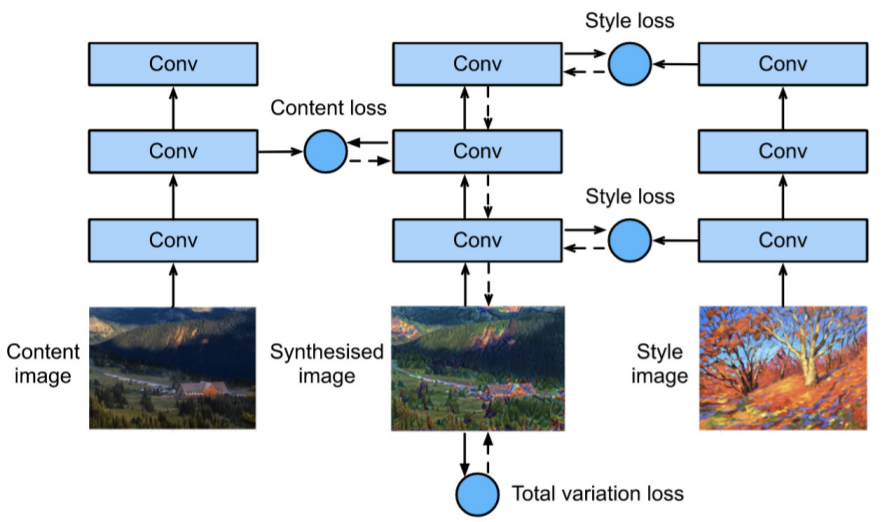

## 代码

### 阅读内容和风格图像


In [1]:
!pip install d2l

In [2]:
import torch
import torchvision

from torch import nn
from d2l import torch as d2l

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**注意**
- `PIL.Image.open(fp, mode='r')`返回的是一个`PIL.Image.Image`对象，代表打开的图像
  - `from PIL import Image`
- `torchvision.io.read_image`返回的是tensor张量

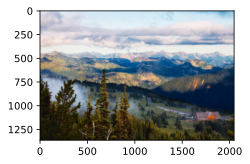

In [22]:
d2l.set_figsize()
content_img = d2l.Image.open('/content/drive/MyDrive/Colab Notebooks/img/rainier.jpg')
# content_img = torchvision.io.read_image('/content/drive/MyDrive/Colab Notebooks/img/rainier.jpg').permute(1, 2, 0)
d2l.plt.imshow(content_img)

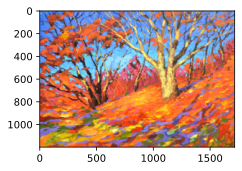

In [24]:
style_img = d2l.Image.open('/content/drive/MyDrive/Colab Notebooks/img/autumn-oak.jpg')
d2l.plt.imshow(style_img)

### 预处理和后处理

预处理函数`preprocess`
- 对输入图像在RGB三个通道分别做标准化，将结果**转化为卷积神经可以处理的tensor**

后处理函数`postprocess`
- 将输出图像中的像素值还原回标准化之前的值（tensor变回图片）
- 图像打印函数要求：像素的浮点数值在0~1之间

维度说明：
- `img`是`(batch_size, c, h, w)`
  - `img[0]`提取单个图像`(c, h, w)`

- `torchvision.transforms.ToPILImage()`是一个**类**，将tensor格式图像转为PIL Image格式
  - PIL格式在处理和可视化图像时更为直观
  - 将形状为**`(channel, height, width)`的tensor**转为PIL图像
  - 而numpy则是`(h, w, c)`

**重要**
- `torchvision.transforms`中的转换函数，期望输入的是**PIL图像**或者**NumPy数组**

In [5]:
rgb_mean =  torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
  transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_shape),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)
  ])
  return transforms(img).unsqueeze(0)

def postprocess(img):
  img = img[0].to(rgb_std.device)  # (c, h, w)
  img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, min=0, max=1)  #(h, w, c)
  return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))  # (h, w, c)

### 抽取图像特征

使用基于ImageNet数据集预训练的**VGG-19**模型来抽取图像特征

In [6]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.1MB/s]


In [7]:
for name, module in pretrained_net.named_modules():
  print(name, type(module))

 <class 'torchvision.models.vgg.VGG'>
features <class 'torch.nn.modules.container.Sequential'>
features.0 <class 'torch.nn.modules.conv.Conv2d'>
features.1 <class 'torch.nn.modules.activation.ReLU'>
features.2 <class 'torch.nn.modules.conv.Conv2d'>
features.3 <class 'torch.nn.modules.activation.ReLU'>
features.4 <class 'torch.nn.modules.pooling.MaxPool2d'>
features.5 <class 'torch.nn.modules.conv.Conv2d'>
features.6 <class 'torch.nn.modules.activation.ReLU'>
features.7 <class 'torch.nn.modules.conv.Conv2d'>
features.8 <class 'torch.nn.modules.activation.ReLU'>
features.9 <class 'torch.nn.modules.pooling.MaxPool2d'>
features.10 <class 'torch.nn.modules.conv.Conv2d'>
features.11 <class 'torch.nn.modules.activation.ReLU'>
features.12 <class 'torch.nn.modules.conv.Conv2d'>
features.13 <class 'torch.nn.modules.activation.ReLU'>
features.14 <class 'torch.nn.modules.conv.Conv2d'>
features.15 <class 'torch.nn.modules.activation.ReLU'>
features.16 <class 'torch.nn.modules.conv.Conv2d'>
features

为了抽取图像的内容特征和风格特征，可以选择VGG网络中的某些层的输出
- 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息
- 内容层：避免合成图像过多保留内容图像的**细节**，选择VGG较靠近输出的层
- 风格层：选择不同层的输出来匹配局部和全局的风格

In [8]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

使用VGG层抽取特征时，只需要用到**从输入层到最靠近输出层的内容层或风格层之间的所有层**

In [9]:
net = nn.Sequential(*[
  pretrained_net.features[i] for i in range(max(content_layers + style_layers) + 1)
])

给定输入`X`如果简单的调用前向传播`net(X)`，只能获得最后一层输出
- 但是需要中间层的输出，要**逐层计算**

In [32]:
def extract_features(X, content_layers, style_layers):
  contents = []
  styles = []
  for i in range(len(net)):
    X = net[i](X)
    if i in content_layers:
      contents.append(X)
    if i in style_layers:
      styles.append(X)
  return contents, styles

- 在训练时**无需改变预训练的VGG模型参数**，可以在训练开始前就提取出内容特征和风格特征
- 合成图像是风格迁移**所需迭代的模型参数**，需要再训练过程中调用`extract_features`函数来抽取合成图像的内容特征和风格特征

In [25]:
def get_contents(image_shape, device):
  content_X = preprocess(content_img, image_shape).to(device)
  contents_Y, _ = extract_features(content_X, content_layers, style_layers)
  return content_X, contents_Y

def get_styles(image_shape, device):
  style_X = preprocess(style_img, image_shape).to(device)
  _, styles_Y = extract_features(content_X, content_layers, style_layers)
  return style_X, styles_Y

### 定义损失函数

#### 风格损失

与线性回归中的损失函数类似，内容损失通过平方误差函数衡量合成图像与内容图像在**内容特征**上的差异

`.detach()`是pytorch中的一个方法，用于从当前计算图中分离张量，使得分离后的张量**不参与反向传播**

In [12]:
def content_loss(Y_hat, Y):
  # 从动态计算梯度的树中分离目标
  return torch.square(Y_hat - Y.detach()).mean()

#### 风格损失

先`extract_features`函数计算风格层的输出
- 假设输出的样本数为1，通道数为$c$，高和宽为`h`和`w`，将输出转换为矩阵`X`，其中有$c$行和$hw$列
  - 可以看作由$c$个长度为$hw$的向量$x_1, ..., x_c$组合而成，其中$x_I$代表通道$i$上的风格特征
- 这些向量的**格拉姆矩阵**$\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$中，$i$行$j$列的元素$x_{ij}$即向量$\mathbf{x}_i$和$\mathbf{x}_j$的**内积**
  - 表达了**通道$i$和通道$j$上风格特征的相关性**
  - 用这样的**格拉姆矩阵来表达风格层输出的风格**
- 需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值
  - 为了让风格损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵**除以了矩阵中元素的个数**，即$chw$

使用**Gram矩阵**来捕获图像的风格特征（而不是具体内容）
- Gram矩阵表示特征图不同通道之间的相关性，能反映图像的纹理和整体风格
- 用于计算特征**图通道间的相似性**

- `//`整除运算，只保留结果的整数部分
- `X.reshape((num_channels, n))`调整形状的目的是计算通道之间的**相关性**

In [36]:
def gram(X):
  num_channels, n = X.shape[1], X.numel() // X.shape[1]
  X = X.reshape((num_channels, n))
  return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
  return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### 全变分损失

有时，学到的合成图像里有大量高频噪点（即有特别亮或特别暗的颗粒像素）
- 变全分去噪（total variation denoising）
  - 假设$x_{i, j}$表示坐标$(i, j)$处的像素值，全变分损失$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$
  - 降低全变分损失能够尽可能使邻近的像素值相似

In [38]:
def tv_loss(Y_hat):
  return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
           torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean())

#### 损失函数

**风格转移的损失函数是内容损失、风格损失和总变化损失的加权和**

In [28]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, content_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
  contents_l = [
    content_loss(Y_hat, Y) * content_weight
    for Y_hat, Y in zip(content_Y_hat, contents_Y)
  ]
  styles_l = [
    style_loss(gram(Y_hat), Y_gram) * style_weight
    for Y_hat, Y_gram in zip(styles_Y_hat, styles_Y_gram)
  ]
  tv_l = tv_loss(X) * tv_weight
  l = sum(10 * styles_l + contents_l + [tv_l])
  return contents_l, styles_l, tv_l, l

### 初始化合成图像

在风格迁移中，合成的图像是训练期间唯一需要更新的变量
- 定义一个模型`SynthesizedImage`，将合成的图像视为模型参数
  - 前向传播只需返回模型参数即可
- 定义函数`get_inits`，创建了合成图像的模型实例，并将其初始化为图像`X`
  - 风格图像在各个风格层的格拉姆矩阵在训练前**预先**算好

- `**kwargs`：接受任意额外的关键字参数，这些参数会被传递给父类的`__init__`方法、

**注意**
- `gen_img()`是**调用了`forward`方法**，实际是触发了模块的前向传播（是模型的计算逻辑的一部分）
- `gen_img.weight`则是类的**属性**，属于`nn.Parameter`类型，即**一个可训练参数**

In [34]:
class SynthesizedImage(nn.Module):
  def __init__(self, img_shape, **kwargs):
    super().__init__(**kwargs)
    self.weight = nn.Parameter(torch.rand(size=img_shape))

  def forward(self):
    return self.weight

def get_inits(X, device, lr, styles_Y):
  gen_img = SynthesizedImage(X.shape).to(device)
  # 将self.weight值替换为输入张量X的数据
  gen_img.weight.data.copy_(X.data)
  trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
  style_Y_gram = [gram(Y) for Y in styles_Y]
  return gen_img(), style_Y_gram, trainer

### 训练模型

在训练模型进行风格迁移时，不断抽取合成图像的内容特征和风格特征，然后计算损失函数
- 使用`lr_decay`

In [40]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epochs):
  X, style_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epochs, 0.8)
  animator = d2l.Animator(
    xlabel='epoch', ylabel='loss', xlim=[10, num_epochs],
    legend=['content', 'style', 'TV'], ncols=2, figsize=(7, 2.5)
  )
  for epoch in range(num_epochs):
    trainer.zero_grad()
    contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)
    contents_l, styles_l, tv_l, l = compute_loss(
      X, contents_Y_hat, styles_Y_hat, contents_Y, style_Y_gram
    )
    l.backward()
    trainer.step()
    scheduler.step()
    if (epoch + 1) % 10 == 0:
      animator.axes[1].imshow(postprocess(X))
      animator.add(
        epoch + 1, [float(sum(contents_l)),
        float(sum(styles_l)), float(tv_l)]
      )
  return X

**训练模型**：
- 先将内容图像和风格图像的高和宽分别调整为300和450像素
- 用内容图像来初始化合成图像

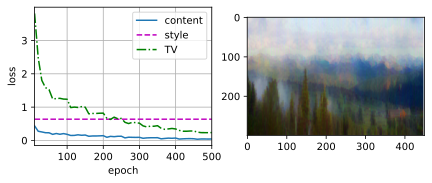

In [41]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)